# State of Health Prediction using LSTM and RUL Estimation using Deterministic Model

Create SoH prediction using LSTM and RUL estimation using Linear Regression for smartphone battery degradation. This notebook include EDA, Feature Engineering, Data Processing, Model Building, and Evaluation.

## Data Preprocessing

### Data Extraction

Extract smartphone data from Supabase collected from smartphone application

In [1]:
# Import necessary modules
import os
import sys
from pathlib import Path

# Define current and root directory paths
CWD = Path().resolve()
ROOT = CWD.parents[0]
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.utils.utils import connect_to_db
from dotenv import load_dotenv
load_dotenv(ROOT / ".env")

# Define database connection parameters
PORT = os.getenv("PORT")
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PASSWORD")
HOST = os.getenv("HOST")
DATABASE = os.getenv("DATABASE")

# Check connection parameters
if not all([PORT, USERNAME, PASSWORD, HOST, DATABASE]):
    print("Error: One or more database connection parameters are missing.")
    sys.exit(1)

# Establish connection to the database
conn = connect_to_db(HOST, PORT, DATABASE, USERNAME, PASSWORD)

Connection to database established successfully.


### Data Convertion

Convert extracted data from Supabase into dataframe format, ensure all the columns matches the data type.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Extract data from the database
with conn.cursor() as cursor:
  cursor.execute("SELECT * FROM public.raw_metrics ORDER BY device_id, created_at ASC")
  data = cursor.fetchall()
  # Convert to DataFrame
  df = pd.DataFrame(data, columns=[desc[0] for desc in cursor.description])

# Ensure sorted data
df["created_at"] = pd.to_datetime(df["created_at"])
df = df.sort_values(["device_id", "created_at"]).reset_index(drop=True)

In [3]:
# Count device id but maximum 500
device_counts = df["device_id"].value_counts().clip(upper=500)
device_counts

device_id
2311DRK48G-b135dcd1d7e9320f          500
SM-A336E-c471046323c8859c            500
SM-S921B-d2c3f5675ad3a14d            500
SM-S931B-57bc0e2d9eac7750            500
SM-S911B-aee10fcb8586030e            500
Infinix X669C-a1b2d29d54d19af3       500
2312DRA50G-223024e791e6150d          500
22021211RG-0940e2943d7b49eb          500
SM-A155F-7d69b63bc200801a            500
SM-S926B-1ccc6862dc88e6b9            500
SM-S916B-205d95c2abec51c0            500
SM-A546E-701861f29b4d5913            500
SM-A356E-4e32dd36015962aa            500
2406APNFAG-4b17a6ddf26cd705          500
SM-A336E-c89e0bb491fe3651            500
SM-A546E-1cf82eec40a3542b            500
SM-A725F-6698366a2e3a4ff1            500
CPH2579-13dc1e10ddca7976             485
vivo 1919-6f29a965f06687bd           479
24117RN76O-af9a140a5e0ea0de          445
SM-A556E-5f0400c50aae82ca            276
SM-A556E-7ecd175336df7fc4            236
SM-A256E-7e0aca17c219854b            204
V2050-b202c09b34bc8540               171
SM-T50

In [4]:
# Convert to Jakarta timezone
import pytz
df['created_at'] = df['created_at'].dt.tz_convert('Asia/Jakarta')
df['ts_utc'] = df['ts_utc'].dt.tz_convert('Asia/Jakarta')

# Check null values
df.isnull().sum()

# Drop unused columns
df.drop(["charge_source", "energy_nwh", "cycles_count", "current_avg_ua"], axis=1).head()

,id,user_id,device_id,ts_utc,net_type,channel_quality,rx_total_bytes,tx_total_bytes,batt_voltage_mv,batt_current_ua,batt_temp_c,is_charging,battery_health,battery_level,charge_counter_uah,battery_capacity_pct,fg_pkg,created_at
0,5f9a61dc-10af-462a-af07-00cc8e452677,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:26:10.349366+07:00,WiFi,-56,2014928638,112746489,3703,623000,35.5,False,GOOD,16.0,518000,16,Device Analytics,2025-11-10 20:26:11.940321+07:00
1,6057bf9c-b150-4ec8-8786-7d731bb7ec94,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:26:11.805850+07:00,WiFi,-56,2014928978,112747759,3703,623000,35.5,False,GOOD,16.0,518000,16,Device Analytics,2025-11-10 20:26:12.630878+07:00
2,d55733e0-af40-45b7-8380-d39ba4f92bec,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:29:59.093424+07:00,WiFi,-54,2045926067,114374859,3586,653000,36.1,False,GOOD,15.0,488000,15,Instagram,2025-11-10 20:30:00.489796+07:00
3,f178b802-d1d3-4280-b371-a4460cccdeed,None,22021211RG-0940e2943d7b49eb,2025-11-10 20:53:21.834407+07:00,WiFi,-59,2055732576,115764715,3467,1524000,32.5,False,GOOD,14.0,437000,14,Device Analytics,2025-11-10 20:53:22.714987+07:00
4,75c65cc2-7db9-4d2e-aab7-9a0caced7ce5,None,22021211RG-0940e2943d7b49eb,2025-11-10 21:09:33.882115+07:00,WiFi,-60,2062366807,117028496,4305,-4525000,36.0,True,GOOD,20.0,612000,20,Discord,2025-11-10 21:09:34.698560+07:00


In [5]:
# Count device IDs rows
df['device_id'].value_counts()

device_id
2311DRK48G-b135dcd1d7e9320f          2327
SM-A336E-c471046323c8859c            2030
SM-S921B-d2c3f5675ad3a14d            1678
SM-S931B-57bc0e2d9eac7750            1658
SM-S911B-aee10fcb8586030e            1536
Infinix X669C-a1b2d29d54d19af3       1370
2312DRA50G-223024e791e6150d          1256
22021211RG-0940e2943d7b49eb          1172
SM-A155F-7d69b63bc200801a            1039
SM-S926B-1ccc6862dc88e6b9             853
SM-S916B-205d95c2abec51c0             824
SM-A546E-701861f29b4d5913             741
SM-A356E-4e32dd36015962aa             720
2406APNFAG-4b17a6ddf26cd705           715
SM-A336E-c89e0bb491fe3651             712
SM-A546E-1cf82eec40a3542b             711
SM-A725F-6698366a2e3a4ff1             681
CPH2579-13dc1e10ddca7976              485
vivo 1919-6f29a965f06687bd            479
24117RN76O-af9a140a5e0ea0de           445
SM-A556E-5f0400c50aae82ca             276
SM-A556E-7ecd175336df7fc4             236
SM-A256E-7e0aca17c219854b             204
V2050-b202c09b34bc8540  

### Histogram Plot

Plot the data columns as histogram plot to extract the insights

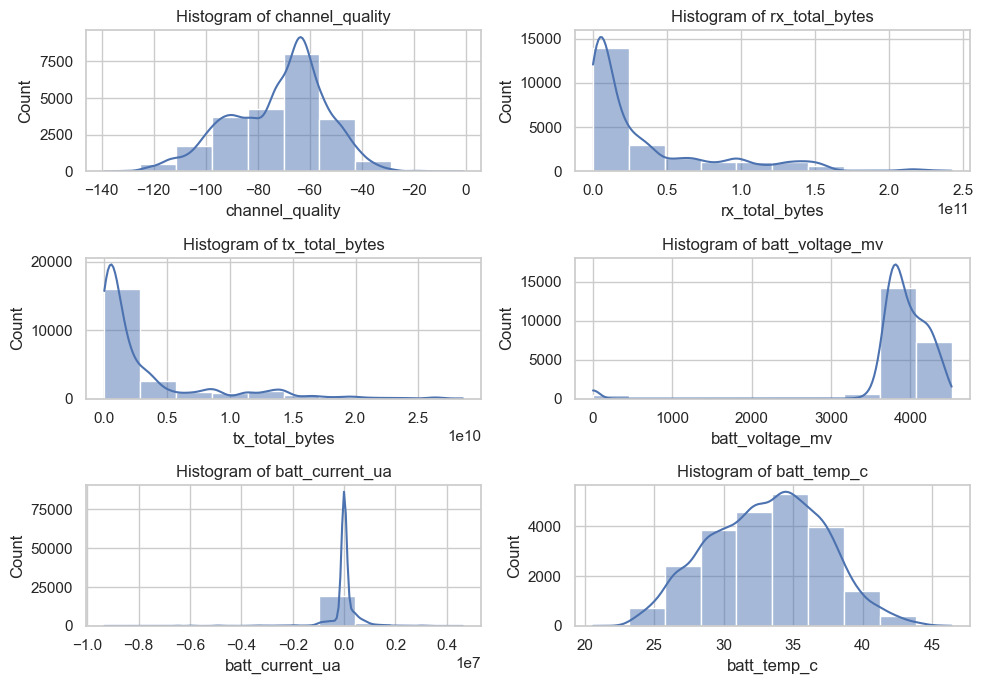

In [6]:
import seaborn as sns

plt.rcParams['agg.path.chunksize'] = 20000

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 7))

# List of numerical columns
numerical_cols = ['channel_quality', 'rx_total_bytes', 'tx_total_bytes', 'batt_voltage_mv',
'batt_current_ua', 'batt_temp_c', "charge_counter", "battery_capacity_pct"]

# Plot histograms for each numerical column
for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(df[col], bins=10, kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

### Throughput and Energy Calculation

Calculate throughput and energy over time from smartphone data collected from Supabase

In [7]:
# Ensure 'created_at' is in datetime format
df["created_at"] = pd.to_datetime(df["created_at"])

# Calculate time difference in seconds
df["delta_t"] = df["created_at"].diff().dt.total_seconds().fillna(0)

# Convert voltage from mV to V and current from uA to A
df["batt_voltage_v"] = df["batt_voltage_mv"] / 1000
df["batt_current_a"] = df["current_avg_ua"] / 1_000_000

# Energi per step (Joule)
df["energy_over_time"] = df["batt_voltage_v"] * df["batt_current_a"] * df["delta_t"]
df["energy_over_time"] = df["energy_over_time"] / 3600

# Calculate throughput
df = df.sort_values("ts_utc")
df["delta_t"] = df["ts_utc"].diff().dt.total_seconds()
df["delta_tx"] = df["tx_total_bytes"].diff()
df["delta_rx"] = df["rx_total_bytes"].diff()

df["throughput_total_bps"] = (df["delta_tx"] + df["delta_rx"]) * 8 / df["delta_t"]

# Drop NaN values
df.loc[df["delta_t"] <= 0, "throughput_total_bps"] = np.nan
df["throughput_total_bps"].replace([np.inf, -np.inf], np.nan, inplace=True)

df["throughput_total_mbps"] = df["throughput_total_bps"] / 1e6

C:\Users\Fadel\AppData\Local\Temp\ipykernel_26528\2251008585.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["throughput_total_bps"].replace([np.inf, -np.inf], np.nan, inplace=True)


### Calculate Energy per Bit

Calculate energy per bit using Throughput metrics. The equation derived from *Energy Model for Data Transfer* paper, alpha and beta values used from paper. 

In [8]:
# Replace zero throughput with NaN to avoid division by zero
df["throughput_total_bps"] = df["throughput_total_bps"].replace(0, np.nan)

# Cofficient from paper
alpha_tx = 446.2936  # nJ/bit
beta_tx = 3.381132   # nJ/bit
alpha_rx = 357.5443  # nJ/bit
beta_rx = 1.969068   # nJ/bit

# Energy per bit calculation
df["energy_per_bit_tx"] = (alpha_tx / df["throughput_total_bps"]) + beta_tx
df["energy_per_bit_rx"] = (alpha_rx / df["throughput_total_bps"]) + beta_rx
df["energy_per_bit_tx_J"] = df["energy_per_bit_tx"] * 1e-9
df["energy_per_bit_rx_J"] = df["energy_per_bit_rx"] * 1e-9

# Energy per bit total calculation
df["energy_per_bit_avg_J"] = (df["energy_per_bit_tx_J"] + df["energy_per_bit_rx_J"]) / 2

# Preview result
df[[
  "ts_utc",
  "throughput_total_bps",
  "energy_per_bit_tx_J",
  "energy_per_bit_rx_J",
  "energy_per_bit_avg_J",
]].head()

,ts_utc,throughput_total_bps,energy_per_bit_tx_J,energy_per_bit_rx_J,energy_per_bit_avg_J
20179,2025-10-31 05:38:28.628023+07:00,NaN,NaN,NaN,NaN
20180,2025-10-31 05:53:30.429297+07:00,1.313596e+06,3.381472e-09,1.969340e-09,2.675406e-09
20181,2025-10-31 06:08:32.072450+07:00,3.407266e+06,3.381263e-09,1.969173e-09,2.675218e-09
20182,2025-10-31 06:23:33.918787+07:00,4.534018e+06,3.381230e-09,1.969147e-09,2.675189e-09
20183,2025-10-31 06:38:35.969953+07:00,5.097230e+06,3.381220e-09,1.969138e-09,2.675179e-09


Calculate battery cost of traffic using average voltage and energy per bit

In [9]:
# Average voltage
V_avg = df["batt_voltage_v"].mean()

# Calculate Battery Cost of Traffic (BoT)
# BoT = (E_b * (8 × 10^9) / V_avg) × (1000 / 3600)
df["BoT_mAh_per_Gbps"] = (df["energy_per_bit_avg_J"] * (8 * 1e9) / V_avg) * (1000 / 3600)

# Preview result
df[["ts_utc", "throughput_total_bps", "energy_per_bit_avg_J", "BoT_mAh_per_Gbps"]].head()

,ts_utc,throughput_total_bps,energy_per_bit_avg_J,BoT_mAh_per_Gbps
20179,2025-10-31 05:38:28.628023+07:00,NaN,NaN,NaN
20180,2025-10-31 05:53:30.429297+07:00,1.313596e+06,2.675406e-09,1.532601
20181,2025-10-31 06:08:32.072450+07:00,3.407266e+06,2.675218e-09,1.532493
20182,2025-10-31 06:23:33.918787+07:00,4.534018e+06,2.675189e-09,1.532477
20183,2025-10-31 06:38:35.969953+07:00,5.097230e+06,2.675179e-09,1.532471


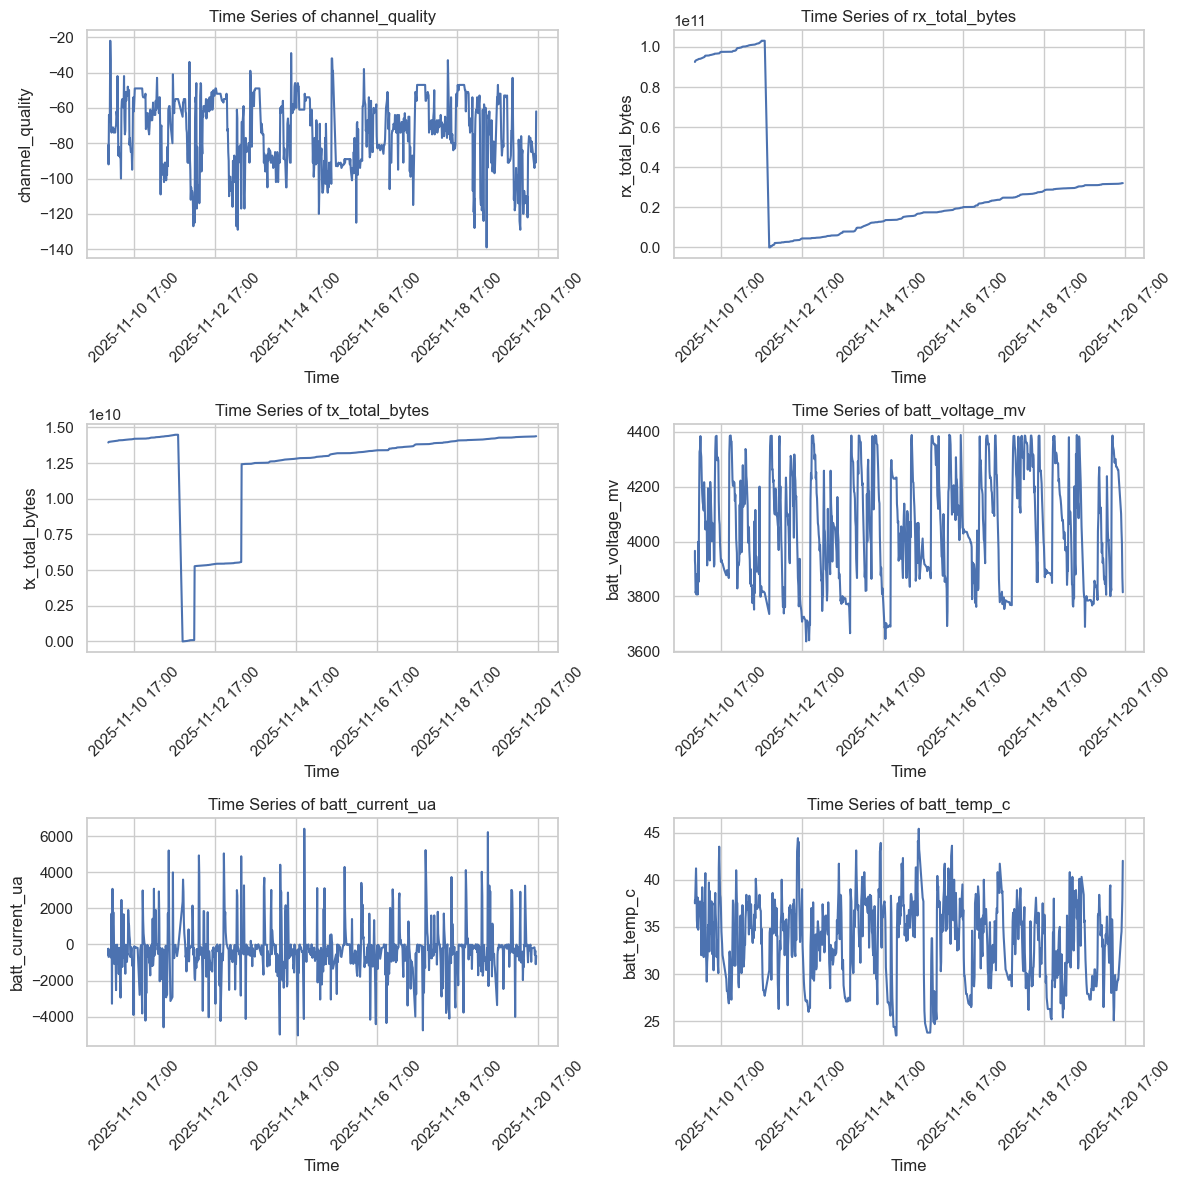

In [10]:
import matplotlib.dates as mdates

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

df_sm = df[df["device_id"] == "SM-S926B-1ccc6862dc88e6b9"]

# Plot line charts for each numerical column
for ax, col in zip(axes.flatten(), numerical_cols):
    ax.plot(df_sm['created_at'], df_sm[col])
    ax.set_title(f'Time Series of {col}')
    ax.set_xlabel('Time')
    ax.set_ylabel(col)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

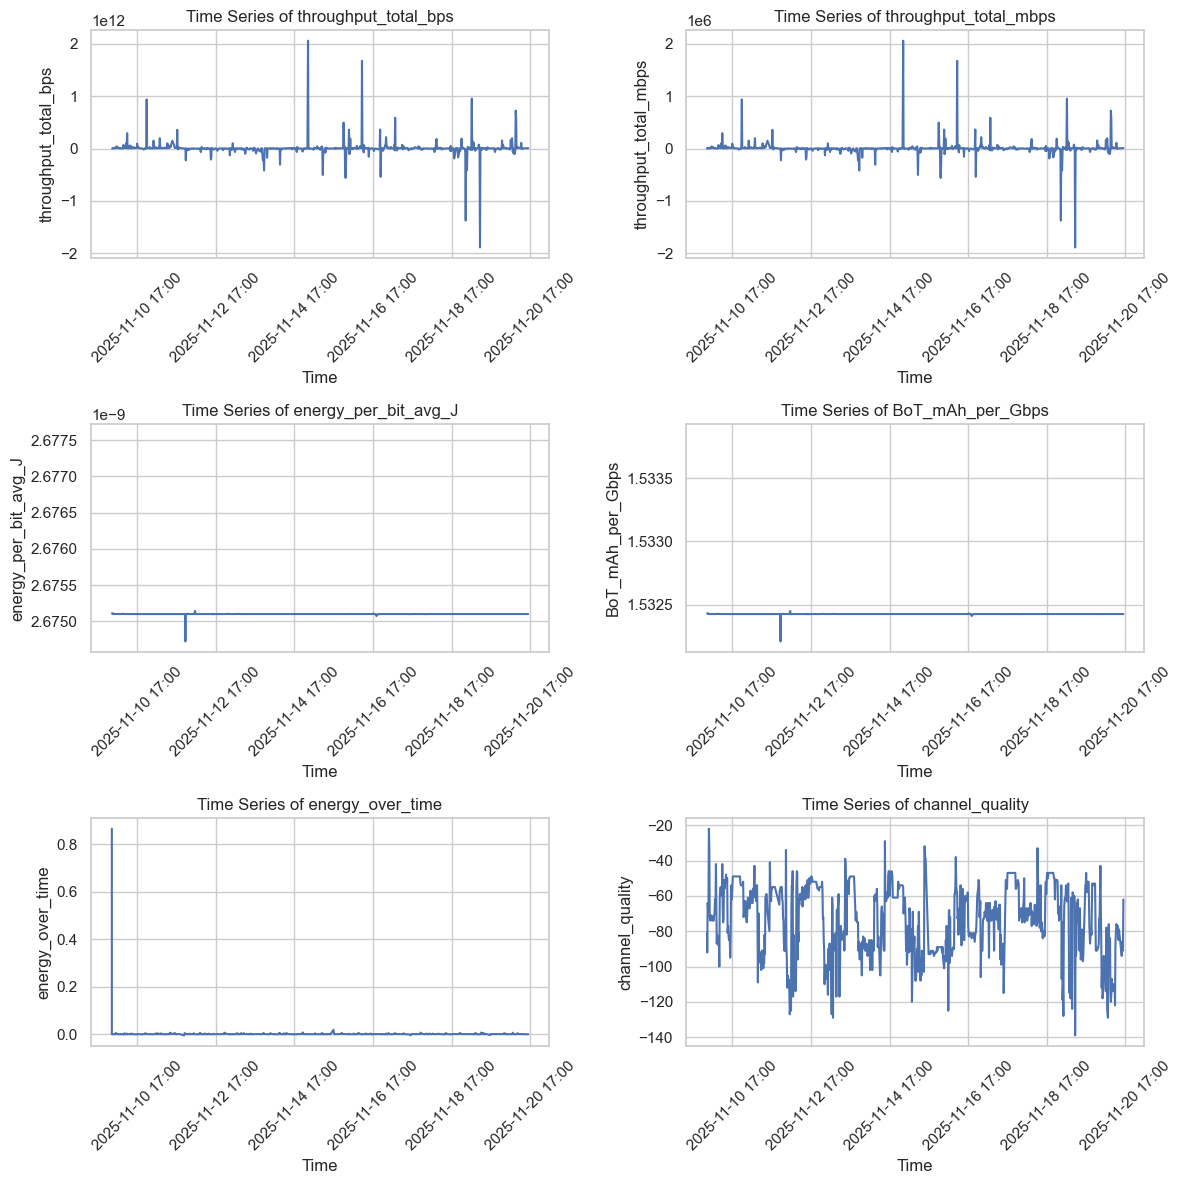

In [11]:
import matplotlib.dates as mdates

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

network_cols = [
  'throughput_total_bps',
  'throughput_total_mbps',
  'energy_per_bit_avg_J',
  'BoT_mAh_per_Gbps',
  "energy_over_time",
  "channel_quality"
]

df_sm = df[df["device_id"] == "SM-S926B-1ccc6862dc88e6b9"]

# Plot line charts for each numerical column
for ax, col in zip(axes.flatten(), network_cols):
    ax.plot(df_sm['created_at'], df_sm[col])
    ax.set_title(f'Time Series of {col}')
    ax.set_xlabel('Time')
    ax.set_ylabel(col)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

## Application Usage Analysis

Create bar plot to see most usage application for every devices collected from smartphone battery application.

C:\Users\Fadel\AppData\Local\Temp\ipykernel_26528\113029621.py:11: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  plt.tight_layout()
c:\College\Bachelor\smartphone-battery-be\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


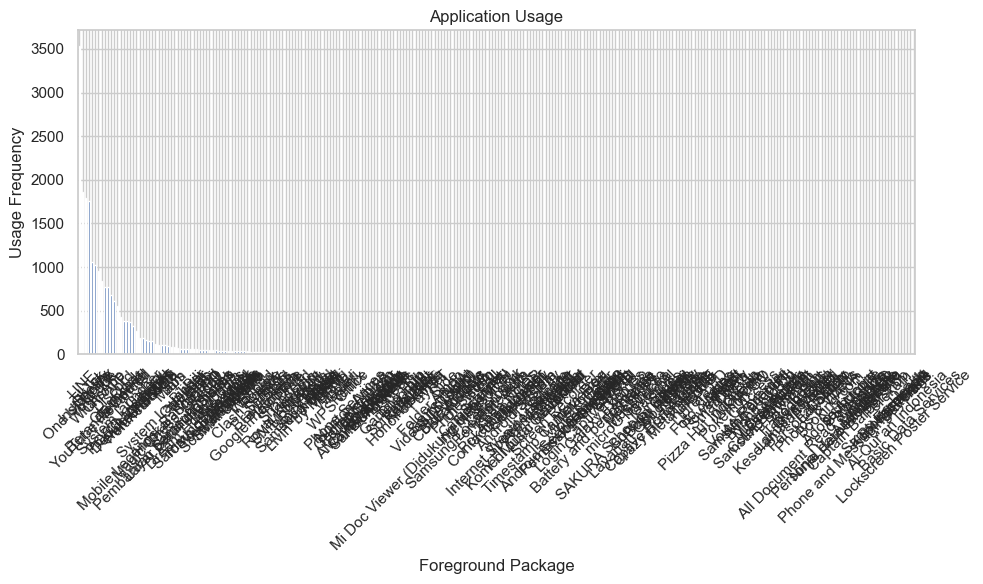

In [12]:
# Count the occurrences of each package
package_counts = df['fg_pkg'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
package_counts.plot(kind='bar')
plt.title('Application Usage')
plt.xlabel('Foreground Package')
plt.ylabel('Usage Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model Building

Create LSTM model to predict smartphone battery State of Health.

In [13]:
import os
import random
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Calculate State of Health and Battery Cycles

Create function to calculate state of health and battery cycles for LSTM prediction

In [14]:
from src.utils.utils import calculate_soh_and_cycles

# Merge device
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df = df.dropna(subset=["created_at"])
df = df.sort_values(["device_id", "created_at"]).reset_index(drop=True)


# Merge SoH calculation for all devices
df_all = (
  df
  .groupby("device_id", group_keys=False)
  .apply(lambda g: calculate_soh_and_cycles(g))
)

df_all["SoH_filled"] = df_all["SoH_smooth"].where(
  df_all["SoH_smooth"].notna(), df_all["SoH"]
)

df_all["SoH_filled"] = (
    df_all.groupby("device_id")["SoH_filled"]
          .transform(lambda s: s.ffill().bfill())
)

C:\Users\Fadel\AppData\Local\Temp\ipykernel_26528\4078386457.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: calculate_soh_and_cycles(g))


In [15]:
df_dev = df_all[df_all["device_id"]=="SM-S916B-205d95c2abec51c0"]
df_dev["Ct_mAh"].describe()

count    803.000000
mean      11.302788
std        6.580671
min        1.993675
25%        5.214191
50%       11.686172
75%       16.824780
max       23.739729
Name: Ct_mAh, dtype: float64

In [16]:
summary = (
    df_all.groupby("device_id")["SoH_filled"]
          .agg(["count", "min", "max", "std"])
          .sort_values("std", ascending=False)
)

summary


,count,min,max,std
device_id,,,,
SM-A256E-7e0aca17c219854b,204,0.122211,1.029379,0.331880
SM-S921B-d2c3f5675ad3a14d,1678,0.111186,1.070414,0.319887
SM-A546E-1cf82eec40a3542b,711,0.019582,1.032220,0.319638
SM-A546E-701861f29b4d5913,741,0.038458,1.060592,0.307861
SM-A336E-c471046323c8859c,2030,0.029451,1.033744,0.305374
SM-S916B-205d95c2abec51c0,824,0.089284,1.061927,0.303541
SM-A356E-4e32dd36015962aa,720,0.122709,1.041791,0.295389
2311DRK48G-b135dcd1d7e9320f,2327,0.005153,1.132573,0.294690
SM-A556E-5f0400c50aae82ca,276,0.028385,1.023289,0.291468


### Device Summary

Create device summary to check minimum and maximum State of Health values

In [17]:
# Device summary
summary = (df_all.groupby("device_id")["SoH_filled"].agg(["count","min","max"]).sort_values("max", ascending=False))
summary

,count,min,max
device_id,,,
2311DRK48G-b135dcd1d7e9320f,2327,0.005153,1.132573
SM-A725F-6698366a2e3a4ff1,681,0.156255,1.128117
SM-S921B-d2c3f5675ad3a14d,1678,0.111186,1.070414
SM-A556E-7ecd175336df7fc4,236,0.157273,1.064545
SM-S916B-205d95c2abec51c0,824,0.089284,1.061927
SM-A546E-701861f29b4d5913,741,0.038458,1.060592
SM-S926B-1ccc6862dc88e6b9,853,0.214005,1.056782
SM-S931B-57bc0e2d9eac7750,1658,1.047619,1.047619
Infinix X669C-a1b2d29d54d19af3,1370,1.047619,1.047619


### Quarantine Devices

Exclude devices that had incomplete State of Health data

In [18]:
from src.utils.utils import quarantine_device

bad_devices = quarantine_device(df_all)
print("Bad devices:", bad_devices)

Bad devices: ['22021211RG-0940e2943d7b49eb', '2311DRK48G-b135dcd1d7e9320f', '23124RA7EO-3eb11a599d8b922d', '2312DRA50G-223024e791e6150d', '2406APNFAG-4b17a6ddf26cd705', 'CPH2579-13dc1e10ddca7976', 'Infinix X6886-e495e4491a5c2a82', 'Redmi Note 9 Pro-d2c7435268ff2367', 'SM-A155F-7d69b63bc200801a', 'SM-A256E-7e0aca17c219854b', 'SM-A336E-c471046323c8859c', 'SM-A336E-c89e0bb491fe3651', 'SM-A356E-4e32dd36015962aa', 'SM-A546E-1cf82eec40a3542b', 'SM-A546E-701861f29b4d5913', 'SM-A546E-8af17d67f9288898', 'SM-A556E-5f0400c50aae82ca', 'SM-A556E-7ecd175336df7fc4', 'SM-A725F-6698366a2e3a4ff1', 'SM-S911B-aee10fcb8586030e', 'SM-S916B-205d95c2abec51c0', 'SM-S921B-d2c3f5675ad3a14d', 'SM-S926B-1ccc6862dc88e6b9', 'SM-T505-280eb41faa621df0', 'V2050-b202c09b34bc8540', 'vivo 1919-6f29a965f06687bd']


Sanity check to ensure the State of Health between 0 - 1.2

In [19]:
# Sanity checks
print("Devices:", df_all["device_id"].nunique(), "Rows:", len(df_all))
assert (df_all["SoH_filled"].dropna().between(0, 1.2)).all()

# EFC per devices
ok = df_all.groupby("device_id")["EFC"].apply(lambda s: (s.diff().fillna(0) >= -1e-9).all())
print("EFC monotonic all devices:", ok.all())

Devices: 29 Rows: 22597
EFC monotonic all devices: True


In [31]:
blacklist_devices = [
  "22021211RG-0940e2943d7b49eb",
  "23124RA7EO-3eb11a599d8b922",
  "2312DRA50G-223024e791e6150d",
  "Redmi Note 9 Pro-d2c7435268ff2367",
  "SM-T505-280eb41faa621df0",
  "vivo 1919-6f29a965f06687bd",
  "CPH2579-13dc1e10ddca7976"
  "V2050-b202c09b34bc8540"
]

df_filtered = df_all[~df_all["device_id"].isin(blacklist_devices)].copy()

In [21]:

print("Before:", len(df_all))
print("After:", len(df_filtered))
print("Dropped:", len(df_all) - len(df_filtered))

Before: 22597
After: 19527
Dropped: 3070


In [22]:
# Pastikan timestamp benar
df_filtered["created_at"] = pd.to_datetime(df_filtered["created_at"], errors="coerce")

# Ambil 500 baris pertama dari setiap device
df_limited = (
    df_filtered.sort_values(["device_id", "created_at"])
      .groupby("device_id")
      .head(500)
      .reset_index(drop=True)
)

# Hitung range tanggal per device setelah limit
df_range = (
    df_limited.groupby("device_id")
              .agg(
                  start_date=("created_at", "min"),
                  end_date=("created_at", "max"),
                  n_samples=("created_at", "count")
              )
              .reset_index()
)

df_range["n_days"] = (df_range["end_date"] - df_range["start_date"]).dt.days + 1

df_range


,device_id,start_date,end_date,n_samples,n_days
0,2311DRK48G-b135dcd1d7e9320f,2025-11-08 20:08:44.893787+07:00,2025-11-14 12:16:08.168324+07:00,500,6
1,23124RA7EO-3eb11a599d8b922d,2025-11-12 11:44:04.977964+07:00,2025-11-12 12:09:13.036442+07:00,4,1
2,2406APNFAG-4b17a6ddf26cd705,2025-11-11 16:05:22.697877+07:00,2025-11-18 00:57:20.272407+07:00,500,7
3,24117RN76O-af9a140a5e0ea0de,2025-11-11 13:53:38.717421+07:00,2025-12-06 08:12:00.766424+07:00,445,25
4,CPH2579-13dc1e10ddca7976,2025-11-30 13:34:23.865974+07:00,2025-12-06 11:15:01.007758+07:00,485,6
5,Infinix X669C-a1b2d29d54d19af3,2025-11-10 13:45:26.841198+07:00,2025-11-19 09:54:56.130128+07:00,500,9
6,Infinix X6886-e495e4491a5c2a82,2025-11-09 16:13:20.068644+07:00,2025-11-30 06:27:52.742212+07:00,37,21
7,SM-A155F-7d69b63bc200801a,2025-11-09 00:16:32.815483+07:00,2025-11-15 12:47:25.578548+07:00,500,7
8,SM-A256E-7e0aca17c219854b,2025-11-14 13:38:05.564415+07:00,2025-12-06 00:03:17.843707+07:00,204,22
9,SM-A336E-c471046323c8859c,2025-11-09 11:17:33.623630+07:00,2025-11-15 20:50:39.347690+07:00,500,7


### Feature Processing

Create Z-Score normalization, also define target and feature columns

In [23]:
from src.utils.utils import add_aging_features

# Define base columns for aging features
AGING_BASE_COLS = [
  "batt_voltage_v",
  "batt_temp_c",
  "throughput_total_mbps",
  "energy_per_bit_avg_J",
  "SoH_filled",
  "EFC",
  "soh_trend",
  "efc_delta",
  "temp_ema",
  "temp_max_win",
  "tp_ema",
  "epb_ema",
]

# Function to add per-device z-score normalization
def add_per_device_zscore(df, cols=AGING_BASE_COLS):
  df = df.copy()
  def _z_per_dev(g):
    for c in cols:
      if c not in g.columns:
        continue
      x = g[c].astype(float)
      mu = x.mean()
      sigma = x.std(ddof=0)
      if sigma == 0 or np.isnan(sigma):
        g[c + "_z"] = 0.0
      else:
        g[c + "_z"] = (x - mu) / sigma
    return g
  df = df.groupby("device_id", group_keys=False).apply(_z_per_dev)
  return df

# Apply per-device z-score normalization
df_fe = add_aging_features(df_filtered)
df_fe = add_per_device_zscore(df_fe)

df_fe = pd.get_dummies(df_fe, columns=["fg_pkg"], prefix="app")
app_cols = [c for c in df_fe.columns if c.startswith("app_")]

# Define final feature columns
feature_cols = [
  "batt_voltage_v", "batt_temp_c",
  "throughput_total_mbps", "energy_per_bit_avg_J",
  "EFC", "soh_trend", "efc_delta",
  "temp_ema", "temp_max_win", "tp_ema", "epb_ema",
  "batt_voltage_v_z", "batt_temp_c_z",
  "throughput_total_mbps_z", "energy_per_bit_avg_J_z",
  "SoH_filled_z", "EFC_z", "soh_trend_z", 'BoT_mAh_per_Gbps', "channel_quality", 
] + app_cols

# Define target column
target_col_soh = "SoH_filled"

C:\College\Bachelor\smartphone-battery-be\src\utils\utils.py:321: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("device_id").apply(_per_dev).reset_index(drop=True)
C:\Users\Fadel\AppData\Local\Temp\ipykernel_26528\1014501351.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("device_id", group_keys=False).apply(_z_per_dev)


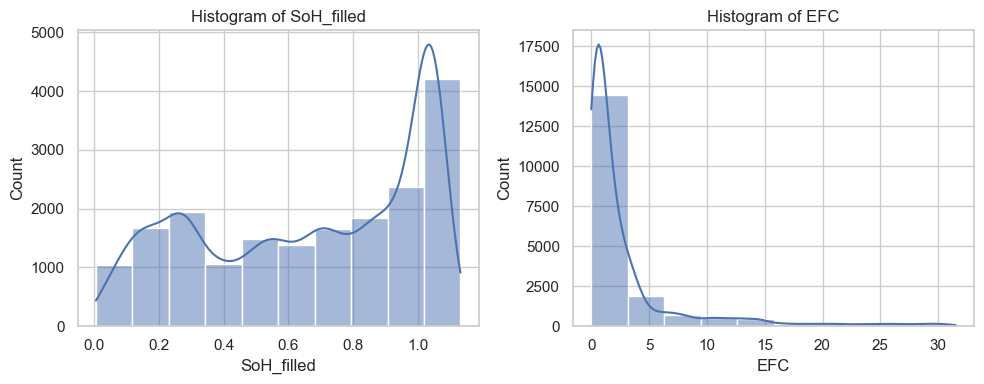

In [24]:
import seaborn as sns

plt.rcParams['agg.path.chunksize'] = 20000

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# List of numerical columns
numerical_cols = ["SoH_filled", "EFC"]

# Plot histograms for each numerical column
for ax, col in zip(axes.flatten(), numerical_cols):
    sns.histplot(df_filtered[col], bins=10, kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

In [25]:
MAX_ROWS = 500

df_limited = (
    df_fe
    .sort_values(["device_id", "created_at"])    
    .groupby("device_id")
    .head(MAX_ROWS)   
    .reset_index(drop=True)
)

print("Before limiting :", df_fe.shape)
print("After limiting  :", df_limited.shape)

# gunakan df_limited untuk seluruh training selanjutnya
df_fe = df_limited

Before limiting : (19527, 302)
After limiting  : (9432, 302)


### Train Test Split

Split data into train, test, and split variation. Also exclude devices that has 100% State of Health

In [72]:
# Set random seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Split device IDs into train, validation, and test sets
device_ids = df_fe["device_id"].dropna().unique()

# Exclude Samsung S25 devices
s25_ids = [d for d in device_ids if str(d).startswith("SM-S931B")]
s23_plus_ids = [d for d in device_ids if str(d).startswith("SM-S916B")]
poco_ids = [d for d in device_ids if str(d).startswith("2311DRK48G")]
a33_ids = [d for d in device_ids if str(d).startswith("SM-A336E-c471046323c8859c")]
vivo_ids = [d for d in device_ids if str(d).startswith("V2050")] 
a25_ids = [d for d in device_ids if str(d).startswith("SM-A256E")]
oppo_ids = [d for d in device_ids if str(d).startswith("CPH2579")]
ra7eo_ids = [d for d in device_ids if str(d).startswith("23124RA7EO")]
fag_ids = [d for d in device_ids if str(d).startswith("2406APNFAG")]
infinix_ids = [d for d in device_ids if str(d).startswith("Infinix X6886")]
rn76o_ids = [d for d in device_ids if str(d).startswith("24117RN76O")]
s23_ids = [d for d in device_ids if str(d).startswith("SM-S911B")]

other_ids = np.array([d for d in device_ids if d not in s25_ids])

# Check devices
print("Total devices:", len(device_ids))
print("S25 (SM-S931B) devices:", s25_ids)
print("S23+ (SM-S916B) devices:", s23_plus_ids)
print("Poco (2311DRK48G) devices:", poco_ids)
print("A33 (SM-A336E) devices:", a33_ids)
print("Vivo (V2050) devices:", vivo_ids)
print("A25 (SM-A256E) devices:", a25_ids)
print("Other devices:", len(other_ids))

Total devices: 24
S25 (SM-S931B) devices: ['SM-S931B-57bc0e2d9eac7750']
S23+ (SM-S916B) devices: ['SM-S916B-205d95c2abec51c0']
Poco (2311DRK48G) devices: ['2311DRK48G-b135dcd1d7e9320f']
A33 (SM-A336E) devices: ['SM-A336E-c471046323c8859c']
Vivo (V2050) devices: ['V2050-b202c09b34bc8540']
A25 (SM-A256E) devices: ['SM-A256E-7e0aca17c219854b']
Other devices: 23


In [75]:
# Shuffle devices
rng.shuffle(other_ids)

# 70% train, 15% val, 15% test
n_train = int(0.7 * len(device_ids))
n_val   = int(0.15 * len(device_ids))

# Assign device IDs to each set
train_ids = device_ids[:n_train]
val_ids   = device_ids[n_train:n_train+n_val]
test_ids  = device_ids[n_train+n_val:]

# Add S25 to train set
train_ids = np.concatenate([train_ids, np.array(s25_ids, dtype=object)])
train_ids = np.concatenate([train_ids, np.array(s23_ids, dtype=object)])
train_ids = np.concatenate([train_ids, np.array(s23_plus_ids, dtype=object)])
train_ids = [d for d in train_ids if d not in oppo_ids]
train_ids = [d for d in train_ids if d not in ra7eo_ids]
train_ids = [d for d in train_ids if d not in fag_ids]
train_ids = [d for d in train_ids if d not in infinix_ids]
train_ids = [d for d in train_ids if d not in rn76o_ids]

val_ids = np.concatenate([val_ids, np.array(rn76o_ids, dtype=object)])
val_ids = [d for d in val_ids if d not in s23_ids]

test_ids = np.concatenate([test_ids, np.array(infinix_ids, dtype=object)])
test_ids = [d for d in test_ids if d not in s23_plus_ids]
test_ids = [d for d in test_ids if d not in s25_ids]
test_ids = [d for d in test_ids if d not in vivo_ids]


# Create DataFrames for each set
df_train = df_fe[df_fe["device_id"].isin(train_ids)].copy()
df_val   = df_fe[df_fe["device_id"].isin(val_ids)].copy()
df_test  = df_fe[df_fe["device_id"].isin(test_ids)].copy()

print("=== SPLIT DEVICES ===")
print("Train IDs:", train_ids)
print("Val IDs  :", val_ids)
print("Test IDs :", test_ids)

=== SPLIT DEVICES ===
Train IDs: ['2311DRK48G-b135dcd1d7e9320f', 'Infinix X669C-a1b2d29d54d19af3', 'SM-A155F-7d69b63bc200801a', 'SM-A256E-7e0aca17c219854b', 'SM-A336E-c471046323c8859c', 'SM-A336E-c89e0bb491fe3651', 'SM-A356E-4e32dd36015962aa', 'SM-A546E-1cf82eec40a3542b', 'SM-A546E-701861f29b4d5913', 'SM-A546E-8af17d67f9288898', 'SM-A556E-5f0400c50aae82ca', 'SM-S931B-57bc0e2d9eac7750', 'SM-S911B-aee10fcb8586030e', 'SM-S916B-205d95c2abec51c0']
Val IDs  : ['SM-A556E-7ecd175336df7fc4', 'SM-A725F-6698366a2e3a4ff1', '24117RN76O-af9a140a5e0ea0de']
Test IDs : ['SM-S921B-d2c3f5675ad3a14d', 'SM-S926B-1ccc6862dc88e6b9', 'Infinix X6886-e495e4491a5c2a82']


### Subset and Scaler

Scale the data and create subset

In [76]:
from sklearn.preprocessing import StandardScaler

# Define preparation function
def prepare_subset(df, feature_cols, target_col):
  df = df.sort_values(["device_id", "created_at"]).copy()
  X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0.0)
  y = df[target_col].astype(float).values
  dev = df["device_id"].astype(str).values
  ts  = pd.to_datetime(df["created_at"]).values
  efc = df["EFC"].astype(float).values
  return X, y, dev, ts, efc

X_tr_raw, y_tr, dev_tr, t_tr, efc_tr = prepare_subset(df_train, feature_cols, target_col_soh)
X_va_raw, y_va, dev_va, t_va, efc_va = prepare_subset(df_val,   feature_cols, target_col_soh)
X_te_raw, y_te, dev_te, t_te, efc_te = prepare_subset(df_test,  feature_cols, target_col_soh)

scaler_X = StandardScaler().fit(X_tr_raw)
X_tr = scaler_X.transform(X_tr_raw)
X_va = scaler_X.transform(X_va_raw)
X_te = scaler_X.transform(X_te_raw)


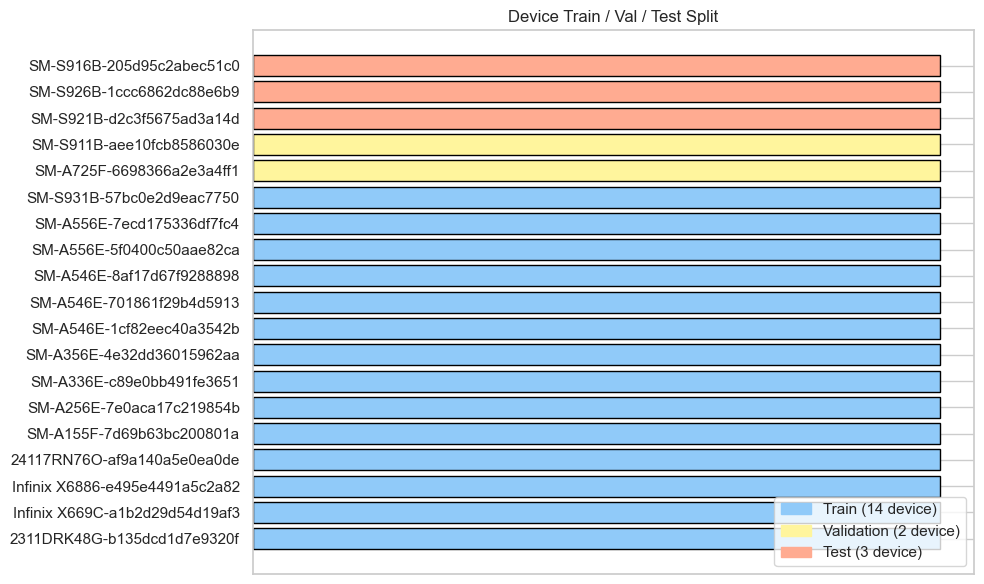

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# =========================================================
# 1. Definisikan device split sesuai yang kamu tulis
# =========================================================

train_ids = [
    '2311DRK48G-b135dcd1d7e9320f',
    'Infinix X669C-a1b2d29d54d19af3',
    'Infinix X6886-e495e4491a5c2a82',
    '24117RN76O-af9a140a5e0ea0de',
    'SM-A155F-7d69b63bc200801a',
    'SM-A256E-7e0aca17c219854b',
    'SM-A336E-c89e0bb491fe3651',
    'SM-A356E-4e32dd36015962aa',
    'SM-A546E-1cf82eec40a3542b',
    'SM-A546E-701861f29b4d5913',
    'SM-A546E-8af17d67f9288898',
    'SM-A556E-5f0400c50aae82ca',
    'SM-A556E-7ecd175336df7fc4',
    'SM-S931B-57bc0e2d9eac7750',
]

val_ids = [
    'SM-A725F-6698366a2e3a4ff1',
    'SM-S911B-aee10fcb8586030e',
]

test_ids = [
    'SM-S921B-d2c3f5675ad3a14d',
    'SM-S926B-1ccc6862dc88e6b9',
    'SM-S916B-205d95c2abec51c0', 
]

# =========================================================
# 2. Cek konsistensi: apakah ada ID yang dobel di dua split?
# =========================================================

train_set = set(train_ids)
val_set   = set(val_ids)
test_set  = set(test_ids)

overlap_train_val  = train_set & val_set
overlap_train_test = train_set & test_set
overlap_val_test   = val_set   & test_set

overlaps = {
    "train-val": overlap_train_val,
    "train-test": overlap_train_test,
    "val-test": overlap_val_test,
}

conflict = {k: v for k, v in overlaps.items() if len(v) > 0}
if conflict:
    raise ValueError(f"Ada device yang muncul di lebih dari satu split: {conflict}")

# =========================================================
# 3. Filter hanya device yang memang ada di df_filtered
# =========================================================

all_ids_defined = train_ids + val_ids + test_ids
devices_in_df = set(df_filtered["device_id"].unique())

devices = [d for d in all_ids_defined if d in devices_in_df]

missing = set(all_ids_defined) - devices_in_df
if missing:
    print("Warning: ada device yang tidak ditemukan di df_filtered:", missing)

# Pastikan total device di plot = jumlah unik dari tiga split
expected_total = len(set(all_ids_defined) & devices_in_df)
assert len(devices) == expected_total, \
    f"Expected {expected_total} devices, got {len(devices)}"

# =========================================================
# 4. Tentukan label split per device
# =========================================================

split_label = []
for d in devices:
    if d in train_set:
        split_label.append("Train")
    elif d in val_set:
        split_label.append("Val")
    elif d in test_set:
        split_label.append("Test")
    else:
        split_label.append("Unknown")  # harusnya ga kejadian

color_map = {
    "Train": "#90CAF9",   # biru muda
    "Val":   "#FFF59D",   # kuning
    "Test":  "#FFAB91",   # oranye
    "Unknown": "#E0E0E0"
}
colors = [color_map[s] for s in split_label]

# =========================================================
# 5. Plot bar horizontal
# =========================================================

plt.figure(figsize=(10, 6))

y_pos = np.arange(len(devices))

plt.barh(y_pos, [1] * len(devices), color=colors, edgecolor="black")

plt.yticks(y_pos, devices)
plt.xticks([])

plt.title("Device Train / Val / Test Split")
plt.xlabel("")

legend_patches = [
    Patch(color=color_map["Train"], label=f"Train ({len(train_set)} device)"),
    Patch(color=color_map["Val"],   label=f"Validation ({len(val_set)} device)"),
    Patch(color=color_map["Test"],  label=f"Test ({len(test_set)} device)"),
]
plt.legend(handles=legend_patches, loc="lower right")

plt.tight_layout()
plt.show()


### Time Sequence

Create function to make a sequence using 24 lookback

In [79]:
def make_sequences(X, y, dev, ts, efc, lookback):
  X_seq, y_seq, dev_seq, t_seq, efc_seq = [], [], [], [], []
  # indeks mulai per device
  df_idx = pd.DataFrame({"device_id": dev, "idx": np.arange(len(dev))})
  for d, rows in df_idx.groupby("device_id"):
    idxs = rows["idx"].values
    if len(idxs) <= lookback:
      continue
    for i in range(lookback, len(idxs)):
      j = idxs[i]
      j0 = idxs[i-lookback:i]
      X_seq.append(X[j0, :])
      y_seq.append(y[j])
      dev_seq.append(d)
      t_seq.append(ts[j])
      efc_seq.append(efc[j])
  return (
    np.array(X_seq, dtype=np.float32),
    np.array(y_seq, dtype=np.float32),
    np.array(dev_seq),
    np.array(t_seq),
    np.array(efc_seq, dtype=np.float32),
  )

# Define lookback window
lookback = 24

# Prepare sequences
X_train, y_train, dev_tr_seq, t_tr_seq, efc_tr_seq = make_sequences(X_tr, y_tr, dev_tr, t_tr, efc_tr, lookback)
X_val,   y_val,   dev_va_seq, t_va_seq, efc_va_seq = make_sequences(X_va, y_va, dev_va, t_va, efc_va, lookback)
X_test,  y_test,  dev_te_seq, t_te_seq, efc_te_seq = make_sequences(X_te, y_te, dev_te, t_te, efc_te, lookback)

print("Train seq:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train seq: (5718, 24, 252) Val: (1109, 24, 252) Test: (965, 24, 252)


### LSTM Architecture

Create LSTM model using 2 layers and ADAM optimization

In [80]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Define features
n_features = X_train.shape[-1]

# Define LSTM model for SoH prediction
inp = layers.Input(shape=(lookback, n_features))
x = layers.Masking(mask_value=0.0)(inp)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.Dropout(0.2)(x)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu")(x)
out_soh = layers.Dense(1, activation="sigmoid", name="soh_out")(x)  # 0–1

# Compile model
model_soh = models.Model(inputs=inp, outputs=out_soh)
model_soh.compile(
  optimizer=tf.keras.optimizers.Adam(1e-3),
  loss="mse",
  metrics=["mae"]
)
model_soh.summary()

cb = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),]

history = model_soh.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=64,
  callbacks=cb,
  verbose=1,
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 252)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 24, 252)   │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 24, 252)   │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 24)        │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 24, 64)    │     81,152 │ masking_1[0][0],  │
│                     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 64)    │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ dropout_2[0][0],  │
│                     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,056 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ soh_out (Dense)     │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 94,657 (369.75 KB)

 Trainable params: 94,657 (369.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0265 - mae: 0.1104 - val_loss: 0.0976 - val_mae: 0.2311
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0025 - mae: 0.0412 - val_loss: 0.1083 - val_mae: 0.2478
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0017 - mae: 0.0334 - val_loss: 0.1121 - val_mae: 0.2515
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0014 - mae: 0.0302 - val_loss: 0.1169 - val_mae: 0.2628
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012 - mae: 0.0276 - val_loss: 0.1085 - val_mae: 0.2520
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011 - mae: 0.0260 - val_loss: 0.1105 - val_mae: 0.2538
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.7860e-04 - mae: 0.0252 - val_loss: 0.1107 - val_mae: 0.2548
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.1197e-04 - mae: 0.0240 - val_loss: 0.1057 - val_mae: 0.2474
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/s

### Evaluation

Create evaluation from training using data test

In [81]:
y_pred = model_soh.predict(X_test).ravel()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred) if np.var(y_test) > 1e-6 else np.nan
print(f"SoH — RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
SoH — RMSE=0.1297, MAE=0.0946, R2=0.7345


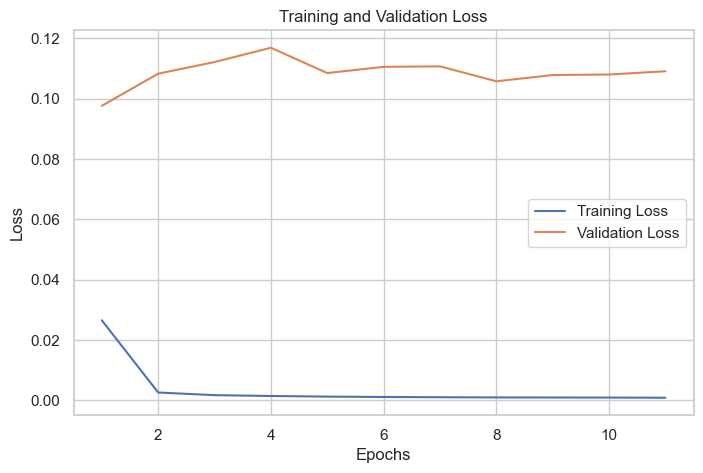

In [82]:
def plot_training_history(history):
  train_loss = history.history.get("loss")
  val_loss = history.history.get("val_loss")
  epochs = range(1, len(train_loss) + 1)
  
  # Plot training & validation loss values
  plt.figure(figsize=(8, 5))
  plt.plot(epochs, train_loss, label='Training Loss')
  if val_loss is not None:
    plt.plot(epochs, val_loss, label='Validation Loss')
  
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.grid(True)
  plt.legend()
  plt.show()

plot_training_history(history)

## RUL Estimation

Create Remaining Useful Life estimation using Linear Regression with constant slope

In [83]:
from sklearn.linear_model import LinearRegression

def estimate_global_degradation_rate(df, soh_col="SoH_filled", efc_col="EFC"):
  slopes = []
  for dev, g in df.groupby("device_id"):
    g = g.dropna(subset=[soh_col, efc_col]).copy()
    if len(g) < 10:
      continue
    if g[efc_col].max() - g[efc_col].min() < 0.05:
      continue  
    X = g[[efc_col]].values
    y = g[soh_col].values
    reg = LinearRegression().fit(X, y)
    b = reg.coef_[0]
    if b < -1e-16:
      slopes.append(b)
  k = 0.2 / 500.0
  print("Warning: no valid slopes, using heuristic k =", k)
  return k

k_global = estimate_global_degradation_rate(df_train)
SoH_eol  = 0.7
print(f"SoH Drop per EFC: {k_global:.6f}, EOL SoH Threshold: {SoH_eol:.2f}")

SoH Drop per EFC: 0.000400, EOL SoH Threshold: 0.70


### Hours per Cycle Estimation

Create hours per cycles estimation

In [84]:
def estimate_hours_per_cycle(df, efc_col="EFC", time_col="created_at"):
  df = df.dropna(subset=[efc_col, time_col]).copy()
  df[time_col] = pd.to_datetime(df[time_col])
  df = df.sort_values(time_col)
    
  total_hours = (df[time_col].max() - df[time_col].min()).total_seconds() / 3600.0
  total_efc   = df[efc_col].max() - df[efc_col].min()
  if total_efc <= 0:
      return None
  return total_hours / total_efc

h_per_cycle = estimate_hours_per_cycle(df_train)
print("Approx hours per EFC:", h_per_cycle)

Approx hours per EFC: 79.8978606601817


### RUL Calculation

Calculate Remaining Useful Life from State of Health prediction

In [85]:
# Compute RUL from SoH
def compute_rul_from_soh(soh_pred, k, soh_eol=0.65, hours_per_cycle=None):
  soh_pred = np.asarray(soh_pred, dtype=float)
  soh_pred = np.clip(soh_pred, 0.0, 1.0)
  
  # RUL in EFC
  rul_cycles = (soh_pred - soh_eol) / k
  rul_cycles = np.maximum(rul_cycles, 0.0)
  if hours_per_cycle is not None:
    rul_hours = rul_cycles * hours_per_cycle
    return rul_cycles, rul_hours
  return rul_cycles, None

rul_cycles_pred, rul_hours_pred = compute_rul_from_soh(
  soh_pred=y_pred,
  k=k_global,
  soh_eol=SoH_eol,
  hours_per_cycle=h_per_cycle,
)

print("RUL_cycles_pred min/max:", rul_cycles_pred.min(), rul_cycles_pred.max())
if rul_hours_pred is not None:
  print("RUL_hours_pred min/max:", rul_hours_pred.min(), rul_hours_pred.max())


RUL_cycles_pred min/max: 0.0 705.9940397739412
RUL_hours_pred min/max: 0.0 56407.41341677713


In [86]:
from sklearn.metrics import root_mean_squared_error

rul_cycles_true, rul_hours_true = compute_rul_from_soh(
  soh_pred=y_test,
  k=k_global,
  soh_eol=SoH_eol,
  hours_per_cycle=h_per_cycle,
)

mae_rul_cycles  = mean_absolute_error(rul_cycles_true, rul_cycles_pred)
rmse_rul_cycles = root_mean_squared_error(rul_cycles_true, rul_cycles_pred)

print("MAE RUL (cycles):", mae_rul_cycles)
print("RMSE RUL (cycles):", rmse_rul_cycles)

if rul_hours_pred is not None:
  mae_rul_hours  = mean_absolute_error(rul_hours_true, rul_hours_pred)
  rmse_rul_hours = root_mean_squared_error(rul_hours_true, rul_hours_pred)
  print("MAE RUL (hours):", mae_rul_hours)
  print("RMSE RUL (hours):", rmse_rul_hours)

MAE RUL (cycles): 141.0143590652881
RMSE RUL (cycles): 229.6498920592658
MAE RUL (hours): 11266.745611683222
RMSE RUL (hours): 18348.53507637699


In [87]:
rul_true = np.asarray(rul_cycles_true, dtype=float).ravel()
rul_pred = np.asarray(rul_cycles_pred, dtype=float).ravel()
rul_abs_err = np.abs(rul_pred - rul_true)

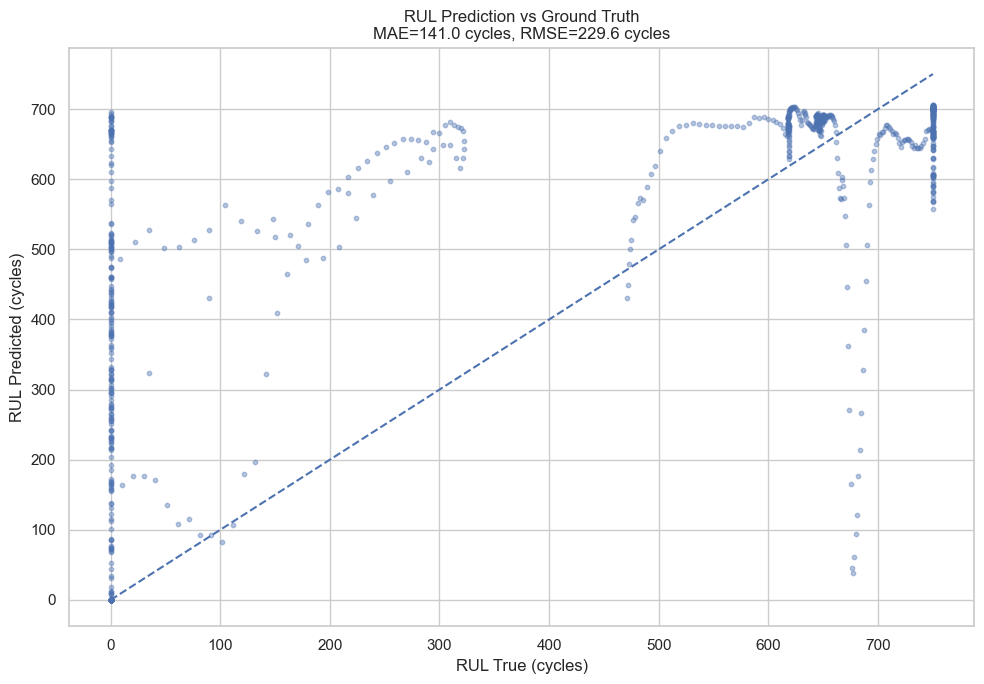

In [88]:
plt.figure(figsize=(10, 7))
plt.scatter(rul_true, rul_pred, alpha=0.4, s=10)
min_v = min(rul_true.min(), rul_pred.min())
max_v = max(rul_true.max(), rul_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--")
plt.xlabel("RUL True (cycles)")
plt.ylabel("RUL Predicted (cycles)")
plt.title(f"RUL Prediction vs Ground Truth\nMAE={mae_rul_cycles:.1f} cycles, RMSE={rmse_rul_cycles:.1f} cycles")
plt.grid(True)
plt.tight_layout()
plt.show()

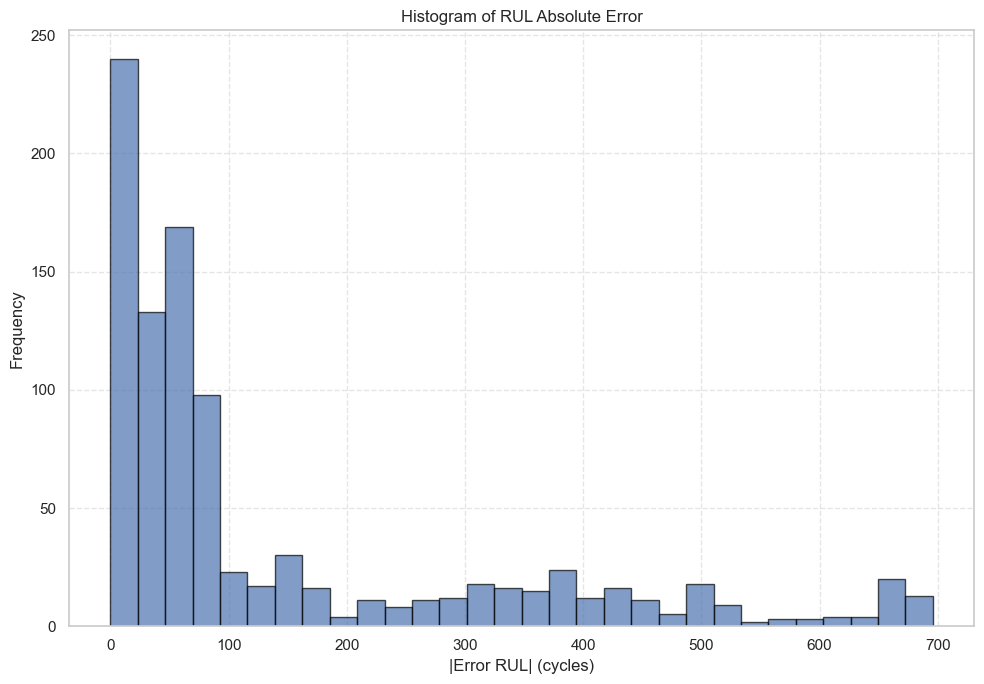

In [89]:
plt.figure(figsize=(10,7))
plt.hist(rul_abs_err, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("|Error RUL| (cycles)")
plt.ylabel("Frequency")
plt.title("Histogram of RUL Absolute Error")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Plot Metrics

Create line plot for every prediction metrics to extract insights for each devices

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

res = pd.DataFrame({
  "device_id": pd.Series(dev_te_seq, dtype=str),
  "created_at": pd.to_datetime(t_te_seq, errors="coerce"),
  "SoH_true":  y_test.astype(float).ravel(),
  "SoH_pred":  y_pred.astype(float).ravel(),
  "RUL_cycles": rul_cycles_pred.astype(float).ravel(),
  "RUL_hours":  rul_hours_pred.astype(float).ravel() if rul_hours_pred is not None else np.nan,
  "EFC": efc_te_seq.astype(float)
})

# Clear NaN/NaT
res = res.dropna(subset=["created_at"]).copy()
print(res.head())

                        device_id                 created_at  SoH_true  \
0  Infinix X6886-e495e4491a5c2a82 2025-11-18 09:42:04.131978  0.816102   
1  Infinix X6886-e495e4491a5c2a82 2025-11-18 13:05:12.330832  0.786593   
2  Infinix X6886-e495e4491a5c2a82 2025-11-18 18:04:12.469743  0.759895   
3  Infinix X6886-e495e4491a5c2a82 2025-11-19 14:19:28.658345  0.735739   
4  Infinix X6886-e495e4491a5c2a82 2025-11-20 01:57:37.856469  0.713884   

   SoH_pred  RUL_cycles     RUL_hours       EFC  
0  0.949617  624.043167  49859.713974  0.337491  
1  0.932167  580.418080  46374.162888  0.337491  
2  0.907036  517.590165  41354.346893  0.337491  
3  0.872104  430.259824  34376.839450  0.337491  
4  0.829231  323.076367  25813.110583  0.337491  


In [91]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def per_device_metrics(res_df):
    rows = []
    for dev, g in res_df.groupby("device_id"):
        y_true = g["SoH_true"].values
        y_pred = g["SoH_pred"].values
        if len(g) < 10:
            continue
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        try:
            r2   = r2_score(y_true, y_pred)
        except ValueError:
            r2 = np.nan
        rows.append((dev, len(g), mae, rmse, r2))
    return pd.DataFrame(rows, columns=["device_id","n","MAE","RMSE","R2"]).sort_values("R2")

df_dev_metrics = per_device_metrics(res)
print(df_dev_metrics)


                        device_id    n       MAE      RMSE        R2
0  Infinix X6886-e495e4491a5c2a82   13  0.096898  0.104407 -1.446530
1       SM-S921B-d2c3f5675ad3a14d  476  0.050588  0.065008 -0.572479
2       SM-S926B-1ccc6862dc88e6b9  476  0.138623  0.172020 -0.036917


### Smoothing

Create smoothing for State of Health and monotonic RUL

In [92]:
# Sort values by device_id and EFC
res = res.sort_values(["device_id", "EFC"]).reset_index(drop=True)
res["SoH_pred_smooth"] = (
  res
    .groupby("device_id")["SoH_pred"]
    .transform(lambda s: (
      s.rolling(window=7, min_periods=1, center=True).mean()
  ))
)

# Smoothing function for RUL to be monotonic decreasing
def smooth_and_monotonic_rul(series, window=7):
  smoothed = series.rolling(window=window, min_periods=1, center=True).mean()
  arr = smoothed.to_numpy()
  mono = np.maximum.accumulate(arr[::-1])[::-1]
  return pd.Series(mono, index=series.index)

# Apply smoothing and monotonic constraint to RUL
res["RUL_cycles_smooth"] = (
  res
    .groupby("device_id")["RUL_cycles"]
    .transform(lambda s: smooth_and_monotonic_rul(s, window=7))
)

In [93]:
# Convert RUL from cycles to hours, days, months, years
rul_hours_pred = rul_cycles_pred * h_per_cycle
rul_days_pred = rul_hours_pred / 24.0
rul_months_pred = rul_days_pred / 30.0
rul_years_pred = rul_days_pred / 365.0

# Add to results DataFrame
res["RUL_hours_pred"] = rul_hours_pred
res["RUL_days_pred"] = rul_days_pred
res["RUL_months_pred"] = rul_months_pred
res["RUL_years_pred"] = rul_years_pred

### Plot SoH and RUL

Create function to plot SoH and RUL based on battery cycles

In [94]:
def plot_soh_rul_vs_cycle(df_plot, device_id, savepath=None):
    # Filter data untuk device tsb
    g = df_plot[df_plot["device_id"] == device_id].copy()
    g = g.dropna(subset=["EFC"])
    if g.empty:
        print(f"[WARN] Tidak ada data EFC untuk device {device_id} setelah merge.")
        return

    g = g.sort_values("EFC")
    g["SoH_true_pct"] = g["SoH_true"] * 100.0
    g["SoH_pred_smooth_pct"] = g["SoH_pred_smooth"] * 100.0

    # =========================
    # FIGURE 1: SoH vs EFC
    # =========================
    plt.figure(figsize=(10, 4))
    plt.plot(g["EFC"], g["SoH_true_pct"], label="SoH True (%)")
    plt.plot(g["EFC"], g["SoH_pred_smooth_pct"], label="SoH Pred (%)", alpha=0.8)
    plt.ylabel("SoH (%)")
    plt.xlabel("Equivalent Full Cycles (EFC)")
    plt.title(f"SoH terhadap Siklus — {device_id}")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if savepath:
        soh_path = f"{savepath}_soh.png"
        plt.savefig(soh_path, dpi=200)
        print("Saved SoH figure:", soh_path)
        plt.close()
    else:
        plt.show()

    # =========================
    # FIGURE 2: RUL vs EFC
    # =========================
    plt.figure(figsize=(10, 4))
    plt.plot(g["EFC"], g["RUL_months_pred"], label="RUL (months)")
    plt.xlabel("Equivalent Full Cycles (EFC)")
    plt.ylabel("RUL (months)")
    plt.title(f"RUL terhadap Siklus — {device_id}")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if savepath:
        rul_path = f"{savepath}_rul.png"
        plt.savefig(rul_path, dpi=200)
        print("Saved RUL figure:", rul_path)
        plt.close()
    else:
        plt.show()


test_devices = res["device_id"].unique()
print(test_devices)


['Infinix X6886-e495e4491a5c2a82' 'SM-S921B-d2c3f5675ad3a14d'
 'SM-S926B-1ccc6862dc88e6b9']


Create SoH and RUL plot for test devices

In [95]:
devices = [0, 1, 2]
os.makedirs("exports", exist_ok=True)
for i in devices:
  sample_dev = test_devices[i]
  plot_soh_rul_vs_cycle(res, sample_dev, savepath=f"exports/{sample_dev}_soh_rul_cycle.png")

Saved SoH figure: exports/Infinix X6886-e495e4491a5c2a82_soh_rul_cycle.png_soh.png
Saved RUL figure: exports/Infinix X6886-e495e4491a5c2a82_soh_rul_cycle.png_rul.png
Saved SoH figure: exports/SM-S921B-d2c3f5675ad3a14d_soh_rul_cycle.png_soh.png
Saved RUL figure: exports/SM-S921B-d2c3f5675ad3a14d_soh_rul_cycle.png_rul.png
Saved SoH figure: exports/SM-S926B-1ccc6862dc88e6b9_soh_rul_cycle.png_soh.png
Saved RUL figure: exports/SM-S926B-1ccc6862dc88e6b9_soh_rul_cycle.png_rul.png


## Feature Correlation

Create feature correlation for LSTM model

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
=== Correlation Feature vs SoH ===
                                  corr_with_SoH_true  corr_with_SoH_pred
SoH_filled_z                                0.971086            0.891931
soh_trend_z                                 0.523963            0.581837
soh_trend                                   0.056082            0.276874
app_Instagram                               0.188939            0.148554
app_YouTube                                 0.193958            0.147468
...                                              ...                 ...
app_maxim 🚕                                      NaN                 NaN
app_microG Services                              NaN                 NaN
app_myBCA                                        NaN                 NaN
app_soundcore                                    NaN                 NaN
app_ All Document Read & Analyze                 NaN                 NaN

[252 rows x 2 columns]


C:\Users\Fadel\AppData\Local\Temp\ipykernel_26528\967358169.py:35: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  plt.tight_layout()
c:\College\Bachelor\smartphone-battery-be\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


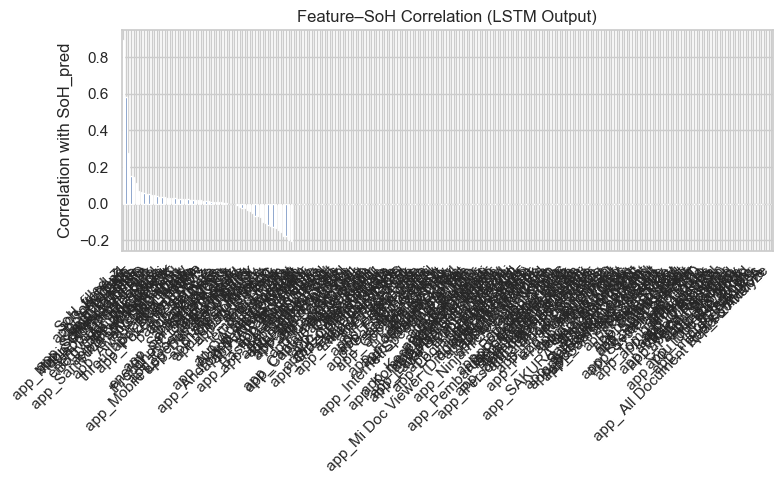

In [96]:
# SoH prediction correlation analysis
y_pred = model_soh.predict(X_test).squeeze()
y_true = y_test.squeeze()

# Flatten sequence data
N, T, F = X_test.shape
X_flat = X_test.reshape(N*T, F)

# Repeat y_true and y_pred for each time step
y_true_rep = np.repeat(y_true, T)
y_pred_rep = np.repeat(y_pred, T)

# Create dataframe for correlation analysis
df_corr = pd.DataFrame(X_flat, columns=feature_cols)
df_corr["SoH_true"] = y_true_rep
df_corr["SoH_pred"] = y_pred_rep

# Calculate Pearson correlation
corr_true = df_corr.corr()["SoH_true"].drop(["SoH_true", "SoH_pred"])
corr_pred = df_corr.corr()["SoH_pred"].drop(["SoH_true", "SoH_pred"])
corr_df = pd.DataFrame({
  "corr_with_SoH_true": corr_true,
  "corr_with_SoH_pred": corr_pred
}).sort_values("corr_with_SoH_pred", ascending=False)

print("=== Correlation Feature vs SoH ===")
print(corr_df)

# Visualize correlation with SoH_pred
plt.figure(figsize=(8, 5))
corr_df["corr_with_SoH_pred"].plot(kind="bar")
plt.ylabel("Correlation with SoH_pred")
plt.title("Feature–SoH Correlation (LSTM Output)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Baseline RMSE: 0.12972111065351674
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\Fadel\AppData\Local\Temp\ipykernel_26528\2903476791.py:42: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  plt.tight_layout()
c:\College\Bachelor\smartphone-battery-be\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128661 (\N{TAXI}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


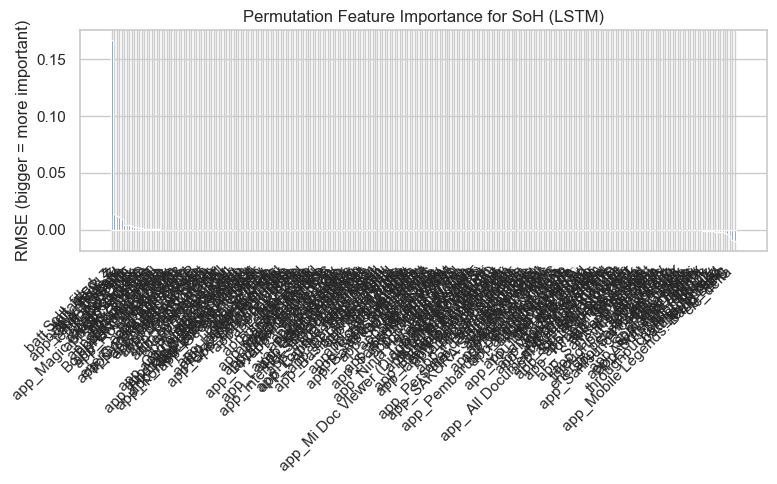

In [97]:
# Create RMSE function
def rmse(a, b):
  return np.sqrt(mean_squared_error(a, b))

# Baseline performance in test set
y_pred_base = model_soh.predict(X_test).squeeze()
y_true = y_test.squeeze()
baseline_rmse = rmse(y_true, y_pred_base)
print("Baseline RMSE:", baseline_rmse)

# Permutation Feature Importance
N, T, F = X_test.shape
importances = []

# Loop through each feature for permutation
for feat_idx, feat_name in enumerate(feature_cols):
  X_perm = X_test.copy()
  idx_perm = np.random.permutation(N)
  X_perm[:, :, feat_idx] = X_test[idx_perm, :, feat_idx]
  
  # Feature prediction with permuted feature
  y_pred_perm = model_soh.predict(X_perm).squeeze()
  rmse_perm = rmse(y_true, y_pred_perm)
  delta_rmse = rmse_perm - baseline_rmse
  importances.append({
    "feature": feat_name,
    "rmse_perm": rmse_perm,
    "delta_rmse": delta_rmse
  })

# Result in dataframe
imp_df = pd.DataFrame(importances).sort_values("delta_rmse", ascending=False)
print("\n=== Permutation Feature Importance (SoH) ===")
print(imp_df)

# Plot bar importance
plt.figure(figsize=(8, 5))
plt.bar(imp_df["feature"], imp_df["delta_rmse"])
plt.ylabel("RMSE (bigger = more important)")
plt.title("Permutation Feature Importance for SoH (LSTM)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [98]:
import os
import json
import pickle
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
export_dir = f"models/{timestamp}"
os.makedirs(export_dir, exist_ok=True)

# Save model
model_soh.save(f"{export_dir}/model.keras")

# Save scaler
with open(f"{export_dir}/scaler.pkl", "wb") as f:
  pickle.dump(scaler_X, f)

# Print if saved
print("[OK] Saved scaler.pkl")
print("Model export directory:", export_dir)

[OK] Saved scaler.pkl
Model export directory: models/20251206_114320


In [99]:
# Create config dictionary
config = {
  "window_size": 24,
  "feature_cols": feature_cols,
  "target_col": "SoH_filled",
  "scaler_type": scaler_X.__class__.__name__,
  "model_version": timestamp,
  "rul_config": {
    "strategy": "global_linear_deterministic",
    "k_global": float(k_global),
    "soh_eol": float(SoH_eol),
    "hours_per_cycle": float(h_per_cycle) if h_per_cycle is not None else None,
    "notes": "k_global ~ average SoH drop per EFC; SoH in fraction [0,1]. "
    "RUL_cycles = max((SoH_pred - soh_eol) / k_global, 0)."
  },
}

# Save config as JSON
with open(f"{export_dir}/config.json", "w") as f:
  json.dump(config, f, indent=2)
print(f"[OK] Saved config.json at {export_dir}")

# Create metdata dictionary
metadata = {
  "created_at": timestamp,
  "num_devices": df["device_id"].nunique(),
  "num_rows": len(df),
}

# Save metadata as JSON
with open(f"{export_dir}/metadata.json", "w") as f:
  json.dump(metadata, f, indent=2)
print(f"[OK] Saved metadata.json at {export_dir}")

[OK] Saved config.json at models/20251206_114320
[OK] Saved metadata.json at models/20251206_114320


In [100]:
# Update latest model
import shutil

latest = "models/latest"
if os.path.exists(latest):
  shutil.rmtree(latest)

shutil.copytree(export_dir, latest)
print(f"[OK] Updated latest model at {latest}")

[OK] Updated latest model at models/latest


In [101]:
# Pisahkan kolom aplikasi & kolom numerik (core)
app_cols = [c for c in feature_cols if c.startswith("app_")]
core_cols = [c for c in feature_cols if c not in app_cols]

print("Jumlah fitur core :", len(core_cols))
print("Jumlah fitur app  :", len(app_cols))

Jumlah fitur core : 20
Jumlah fitur app  : 232


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
=== Correlation (core features vs SoH_pred) ===


,corr_with_SoH_pred
SoH_filled_z,0.891931
soh_trend_z,0.581837
soh_trend,0.276874
BoT_mAh_per_Gbps,0.034282
energy_per_bit_avg_J,0.034282
batt_voltage_v_z,0.029006
throughput_total_mbps,0.019155
EFC_z,0.010655
batt_temp_c_z,0.010267
energy_per_bit_avg_J_z,-0.004525



=== Correlation (app features vs SoH_pred) ===


,corr_with_SoH_pred
app_Instagram,0.148554
app_YouTube,0.147468
app_LINE,0.112771
app_Threads,0.069497
app_Chrome,0.061403
...,...
app_maxim 🚕,NaN
app_microG Services,NaN
app_myBCA,NaN
app_soundcore,NaN


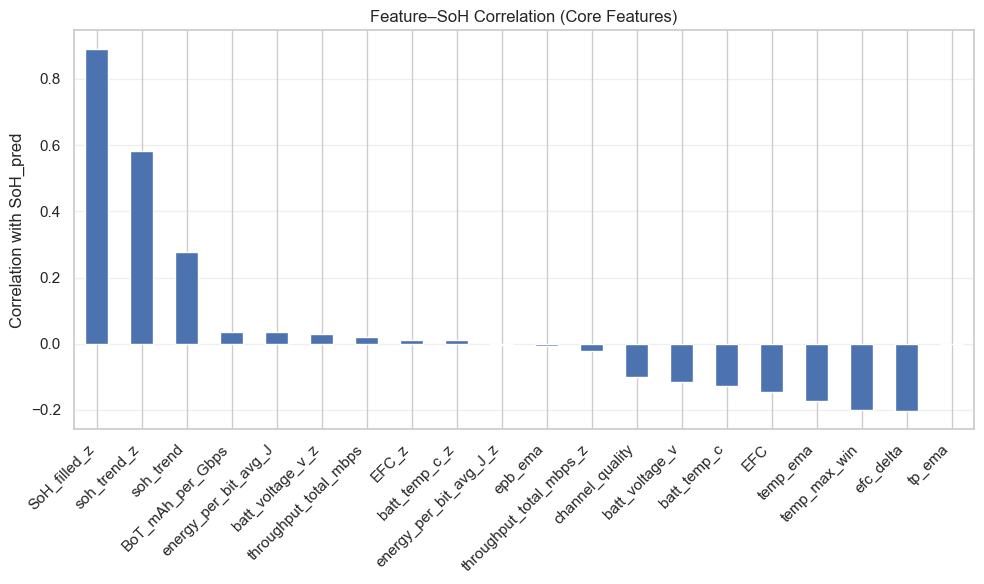

In [102]:
# ============================================
# SoH prediction correlation analysis (split core vs app)
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prediksi SoH di test set
y_pred = model_soh.predict(X_test).squeeze()
y_true = y_test.squeeze()

# 2. Flatten sequence: (N, T, F) -> (N*T, F)
N, T, F = X_test.shape
X_flat = X_test.reshape(N * T, F)

# 3. Repeat y_true & y_pred supaya align dengan tiap time-step
y_true_rep = np.repeat(y_true, T)
y_pred_rep = np.repeat(y_pred, T)

# 4. DataFrame untuk korelasi
df_corr = pd.DataFrame(X_flat, columns=feature_cols)
df_corr["SoH_true"] = y_true_rep
df_corr["SoH_pred"] = y_pred_rep

# 5. Hitung korelasi Pearson
corr_matrix = df_corr.corr()

# Kita fokus ke korelasi terhadap SoH_pred
corr_pred_all = corr_matrix["SoH_pred"].drop(["SoH_true", "SoH_pred"])

# 6. Split fitur: core (numeric) vs app (one-hot)
#    app_cols sudah didefinisikan sebelumnya waktu get_dummies
core_cols = [c for c in feature_cols if c not in app_cols]

corr_core = corr_pred_all[core_cols].sort_values(ascending=False)
corr_app  = corr_pred_all[app_cols].sort_values(ascending=False)

print("=== Correlation (core features vs SoH_pred) ===")
display(corr_core.to_frame(name="corr_with_SoH_pred"))

print("\n=== Correlation (app features vs SoH_pred) ===")
display(corr_app.to_frame(name="corr_with_SoH_pred"))

# 7. Plot: CORE FEATURES
plt.figure(figsize=(10, 6))
corr_core.plot(kind="bar")
plt.ylabel("Correlation with SoH_pred")
plt.title("Feature–SoH Correlation (Core Features)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



=== Correlation (app features vs SoH_pred) – non-zero only ===


,corr_with_SoH_pred
app_TikTok,-0.177095
app_Clock,-0.157124
app_Instagram,0.148554
app_YouTube,0.147468
app_WhatsApp,-0.131717
app_One UI Home,-0.124584
app_LINE,0.112771
app_Clash Royale,-0.104662
app_X,-0.075464
app_Threads,0.069497


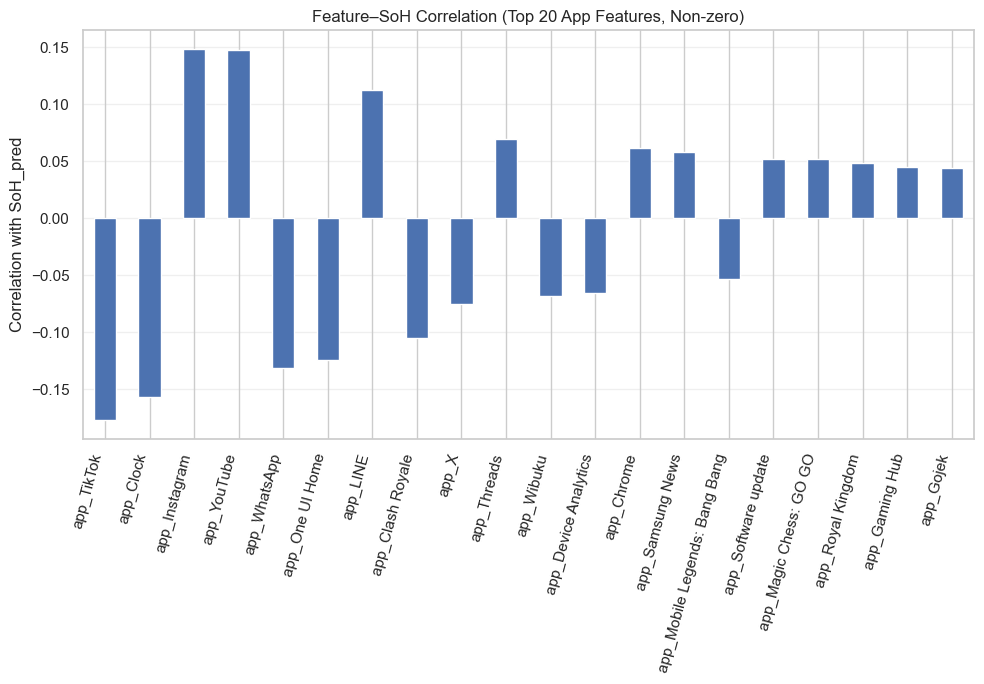

In [103]:
# 8. Plot: APP FEATURES (one-hot aplikasi)
# --- Korelasi app features (one-hot aplikasi) ---
# corr_app = corr_pred_all[app_cols].sort_values(ascending=False)  # ini baris lama

corr_app = corr_pred_all[app_cols].sort_values(ascending=False)

# Filter: hanya yang punya nilai dan tidak nol
corr_app_filtered = corr_app[~corr_app.isna() & (corr_app != 0.0)]

# Opsional: kalau masih kebanyakan, ambil TOP-N saja (misal 20 terbesar absolut)
TOP_N = 20
corr_app_top = corr_app_filtered.reindex(
    corr_app_filtered.abs().sort_values(ascending=False).head(TOP_N).index
)

print("\n=== Correlation (app features vs SoH_pred) – non-zero only ===")
display(corr_app_top.to_frame(name="corr_with_SoH_pred"))

plt.figure(figsize=(10, 7))
corr_app_top.plot(kind="bar")
plt.ylabel("Correlation with SoH_pred")
plt.title(f"Feature–SoH Correlation (Top {TOP_N} App Features, Non-zero)")
plt.xticks(rotation=75, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# === RMSE helper ===
def rmse(a, b):
    return np.sqrt(mean_squared_error(a, b))

# === Baseline performance di test set ===
y_true = y_test.squeeze()
y_pred_base = model_soh.predict(X_test).squeeze()
baseline_rmse = rmse(y_true, y_pred_base)
print("Baseline RMSE:", baseline_rmse)

# === Split fitur: core vs app ===
app_cols = [c for c in feature_cols if c.startswith("app_")]
core_cols = [c for c in feature_cols if c not in app_cols]

print("Jumlah core features :", len(core_cols))
print("Jumlah app features  :", len(app_cols))

# === Permutation Feature Importance ===
N, T, F = X_test.shape
importances = []

# Flatten sekali di awal biar rapi
X_flat_orig = X_test.reshape(N * T, F)

for feat_idx, feat_name in enumerate(feature_cols):
    # Copy flatten
    X_flat_perm = X_flat_orig.copy()

    # Permutasi satu kolom fitur ini (acak di semua time-step & sequence)
    X_flat_perm[:, feat_idx] = np.random.permutation(X_flat_perm[:, feat_idx])

    # Kembalikan ke bentuk (N, T, F)
    X_perm = X_flat_perm.reshape(N, T, F)

    # Prediksi lagi dengan fitur yang di-permute
    y_pred_perm = model_soh.predict(X_perm).squeeze()
    rmse_perm = rmse(y_true, y_pred_perm)
    delta_rmse = rmse_perm - baseline_rmse

    importances.append({
        "feature": feat_name,
        "rmse_perm": rmse_perm,
        "delta_rmse": delta_rmse,
    })

# DataFrame semua fitur
imp_df = pd.DataFrame(importances).sort_values("delta_rmse", ascending=False)
print("\n=== Permutation Feature Importance (All Features) ===")
display(imp_df)

# ============================
# Pisah: CORE vs APP features
# ============================
imp_core = imp_df[imp_df["feature"].isin(core_cols)].copy()
imp_app  = imp_df[imp_df["feature"].isin(app_cols)].copy()

# Filter: hanya yang punya nilai dan delta_rmse != 0
imp_core = imp_core[imp_core["delta_rmse"].notna() & (imp_core["delta_rmse"] != 0.0)]
imp_app  = imp_app[imp_app["delta_rmse"].notna() & (imp_app["delta_rmse"] != 0.0)]

# Opsional: ambil TOP-N
TOP_N_CORE = 20
TOP_N_APP  = 20

imp_core_top = imp_core.sort_values("delta_rmse", ascending=False).head(TOP_N_CORE)
imp_app_top  = imp_app.sort_values("delta_rmse",  ascending=False).head(TOP_N_APP)

print(f"\n=== TOP {TOP_N_CORE} Core Features (by ΔRMSE) ===")
display(imp_core_top)

print(f"\n=== TOP {TOP_N_APP} App Features (by ΔRMSE) ===")
display(imp_app_top)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Baseline RMSE: 0.12972111065351674
Jumlah core features : 20
Jumlah app features  : 232
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
31/31 ━━━━━━━━━

,feature,rmse_perm,delta_rmse
15,SoH_filled_z,0.233591,0.103870
16,EFC_z,0.141574,0.011853
11,batt_voltage_v_z,0.139665,0.009943
17,soh_trend_z,0.138684,0.008963
0,batt_voltage_v,0.136526,0.006805
...,...,...,...
98,app_Google,0.127790,-0.001931
7,temp_ema,0.126874,-0.002847
138,app_Mobile Legends: Bang Bang,0.125696,-0.004025
6,efc_delta,0.116855,-0.012866



=== TOP 20 Core Features (by ΔRMSE) ===


,feature,rmse_perm,delta_rmse
15,SoH_filled_z,0.233591,0.103870
16,EFC_z,0.141574,0.011853
11,batt_voltage_v_z,0.139665,0.009943
17,soh_trend_z,0.138684,0.008963
0,batt_voltage_v,0.136526,0.006805
8,temp_max_win,0.131856,0.002135
10,epb_ema,0.129786,0.000065
2,throughput_total_mbps,0.129709,-0.000012
3,energy_per_bit_avg_J,0.129681,-0.000040
14,energy_per_bit_avg_J_z,0.129655,-0.000066



=== TOP 20 App Features (by ΔRMSE) ===


,feature,rmse_perm,delta_rmse
70,app_Discord,0.134669,0.004948
218,app_Threads,0.133840,0.004119
149,app_One UI Home,0.132437,0.002716
144,app_Netflix,0.132257,0.002536
241,app_YouTube,0.132087,0.002365
119,app_LINE,0.131788,0.002067
62,app_Chrome,0.130824,0.001102
64,app_Clock,0.130751,0.001030
130,app_Magic Chess: GO GO,0.130704,0.000982
221,app_Tokopedia,0.130537,0.000816


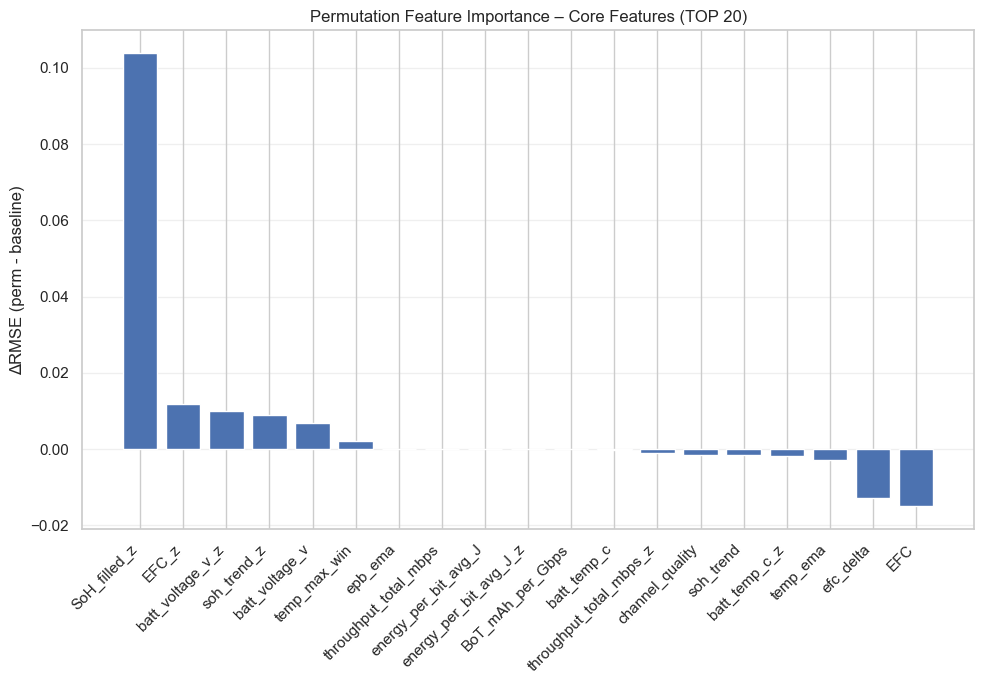

In [105]:
# =========
# PLOT CORE
# =========
plt.figure(figsize=(10, 7))
plt.bar(imp_core_top["feature"], imp_core_top["delta_rmse"])
plt.ylabel("ΔRMSE (perm - baseline)")
plt.title(f"Permutation Feature Importance – Core Features (TOP {TOP_N_CORE})")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

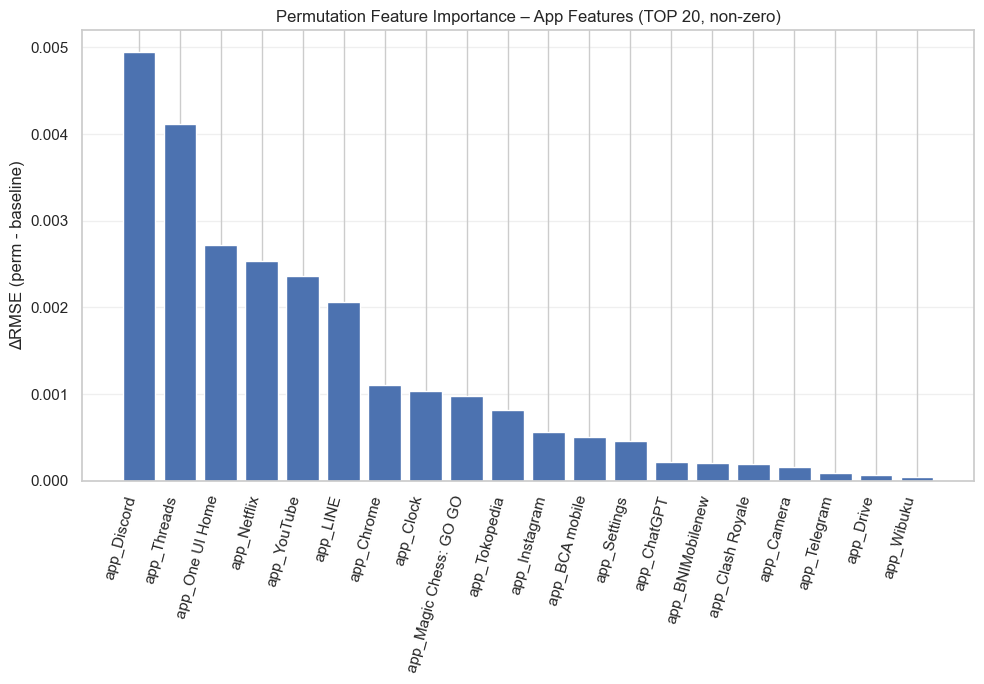

In [106]:
# ========
# PLOT APP
# ========
plt.figure(figsize=(10, 7))
plt.bar(imp_app_top["feature"], imp_app_top["delta_rmse"])
plt.ylabel("ΔRMSE (perm - baseline)")
plt.title(f"Permutation Feature Importance – App Features (TOP {TOP_N_APP}, non-zero)")
plt.xticks(rotation=75, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()